# Kunskapskontroll 2 del 1

## Frågor:
1. Lotta delar upp sin data i ”Träning”, ”Validering” och ”Test”, vad används respektive del för?
2. Förklara (gärna med ett exempel): Ordinal encoding, one-hot encoding, dummy variable encoding.
3. Göran påstår att datan antingen är ”ordinal” eller ”nominal”. Julia säger att detta måste tolkas. Hon ger ett exempel med att färger såsom {röd, grön, blå} generellt sett inte har någon inbördes ordning (nominal) men om du har en röd skjorta så är du vackrast på festen (ordinal) – vem har rätt?
4. Läs följande länk: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn (speciellt svaret från användaren som heter ”sentence”) som beskriver ”joblib” och ”pickle”. Det är alltså ett sätt att spara modeller och innebär att man kan träna en modell och sedan återanvända den för att göra prediktioner utan att behöva träna om modellen. Detta kommer ni ha nytta av om ni satsar på VG delen. Svara på frågan: Vad används joblib och pickle till?

## Svar:
##### 1. Träning används för att träna modellen. Den hittar då de bästa inställningarna på olika parametrar.
##### 2.a Ordinal encoding: Omvandlar värden till heltal. Används när kategorin av data har en rangordning, t.ex. First, second, third eller High, Medium, Low
##### 2.b one-hot-encoding: Omvandlar värden till binära värden. Om tre olika värden finns i kategorin används tre siffror för talet, [1,0,0], [0,1,0], [0,0,1] där varje siffras plats motsvarar ett värde. Används när kategorin av data inte har någon rangordning som t.ex. olika färger.
##### 2.c dummy variable encoding: Som föregående men om kategorin har tre olika värden används bara två siffror[1,0], [0,1]. Det tredje värdet ersätts av [0,0].
##### 3. Det beror på vad frågan är. Om frågan gäller färgers egenskaper kan de ha en rangordning. Vill man t.ex. veta hur varm eller kall en färg är så har de en rangordning. Eller hur mycket gult en färg har i sig. Men om frågan inte gäller färgers egenskaper så har de troligen ingen rangordning
##### 4. Pickle och joblib används för att spara en tränad modell till en fil som man sedan kan ladda från filen i en annan applikation. Vid stora datamängder eller modeller som inkluderar numpy-arrayer är joblib lämpligare. Pickle ingår som standardbibliotek i python vilket inte joblib gör.

### Modellera MNIST
##### Använd maskininlärning för att modellera MNIST datan. Du skall utvärdera minst två olika modeller i ditt arbete och göra ett komplett ML-flöde, från början, där du laddar in data, till slut, där du utvärderar den bäst valda modellen på din test data.

In [102]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler

In [100]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [104]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [106]:
#Jag använder de första 5000 posterna till träningsdata
X_train = X[:5000]
y_train = y[:5000]

#Jag använder nästföljande 1000 poster till validering
X_val = X[5000:6000]
y_val = y[5000:6000]

#Och nästa 1000 till test
X_test = X[6000:7000]
y_test = y[6000:7000]

In [108]:
#Skalar data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_train_small_1_scaled = scaler.transform(X_train_small_1)
#X_train_small_2_scaled = scaler.transform(X_train_small_2)
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)

In [110]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)
#print("X_train_small_1_scaled shape:", X_train_small_1_scaled.shape)
#print("y_train_small_1 shape:", y_train_small_1.shape)
#print("X_train_small_2_scaled shape:", X_train_small_2_scaled.shape)
#print("y_train_small_2 shape:", y_train_small_2.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("y_val shape:", y_val.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)
print("Unika värden i y_train:", np.unique(y_train))

X_train_scaled shape: (5000, 784)
y_train shape: (5000,)
X_val_scaled shape: (1000, 784)
y_val shape: (1000,)
X_test_scaled shape: (1000, 784)
y_test shape: (1000,)
Unika värden i y_train: [0 1 2 3 4 5 6 7 8 9]


In [112]:
print("Minsta värde i y_train:", np.min(y_train))
print("Högsta värde i y_train:", np.max(y_train))

Minsta värde i y_train: 0
Högsta värde i y_train: 9


#### Jag har valt att jämföra SGDClassifier med RandomForestClassifier.
##### För SGDClassifier använder jag GridSearch för att hitta de bästa av mina utvalda värden på parametrarna loss, penalty, alpha och jag sätter max_iter=1000. 
##### För RandomForestClassifier använder jag GridSearch för att hitta de bästa av mina utvalda värden på parametrarna n_estimators, max_depth, och min_samples_split.
##### Jag använder sedan den bästa modellen för att prediktera y-värdet med skalat valideringsdata och skriver ut accuracy_score,  classification_report och ConfusionMatrix. Vid jämförelse väljer jag en modell och predikterar y-värdet med skalat testdata och skriver ut accuracy_score, classification_report och ConfusionMatrix.

In [115]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_scaled, y_train)
print("Träningsnoggrannhet:", sgd_clf.score(X_train_scaled, y_train))

Träningsnoggrannhet: 0.9584


In [119]:

param_grid = {'loss': ['hinge', 'log_loss'],  
    'penalty': ['l1', 'l2'],           
    'alpha': [0.0001, 0.0005],                 
    'max_iter': [1000] }

grid_search = GridSearchCV(estimator=SGDClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  
    verbose=2,
    n_jobs=1)

try:
    grid_search.fit(X_train_scaled, y_train)
except ValueError as e:
    print("Ett värdefel uppstod:", e)
except NotFittedError as e:
    print("Modellen kunde inte tränas:", e)
except Exception as e:
    print("Ett annat fel uppstod:", e)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time= 1.1min
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time= 1.6min
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time= 1.3min
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=  10.7s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=  18.4s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=  13.8s
[CV] END alpha=0.0001, loss=log_loss, max_iter=1000, penalty=l1; total time= 1.3min
[CV] END alpha=0.0001, loss=log_loss, max_iter=1000, penalty=l1; total time= 2.1min
[CV] END alpha=0.0001, loss=log_loss, max_iter=1000, penalty=l1; total time= 2.0min
[CV] END alpha=0.0001, loss=log_loss, max_iter=1000, penalty=l2; total time=  22.0s
[CV] END alpha=0.0001, loss=log_loss, max_iter=1000, penalty=l2; total time=  44.0s
[CV] END alpha=0.0001, loss=log_lo

In [122]:
best_model_SGD = grid_search.best_estimator_
print(f"Bästa parametrar: {grid_search.best_params_}")

Bästa parametrar: {'alpha': 0.0005, 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l2'}


In [124]:
# Utvärdera den bästa modellen
y_pred_val_SGD = best_model.predict(X_val_scaled)
accuracySGD = accuracy_score(y_val, y_pred_val_SGD)
print(f"\nAccuracy med bästa modellen: {accuracySGD:.2f}")

# Detaljerad rapport
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val_SGD))


Accuracy med bästa modellen: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       113
           1       0.94      0.94      0.94       108
           2       0.89      0.78      0.83        93
           3       0.88      0.92      0.90       115
           4       0.87      0.86      0.87        88
           5       0.84      0.81      0.83        80
           6       0.92      0.93      0.93       107
           7       0.93      0.85      0.89       101
           8       0.82      0.85      0.84        89
           9       0.82      0.92      0.86       106

    accuracy                           0.89      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.89      0.89      1000



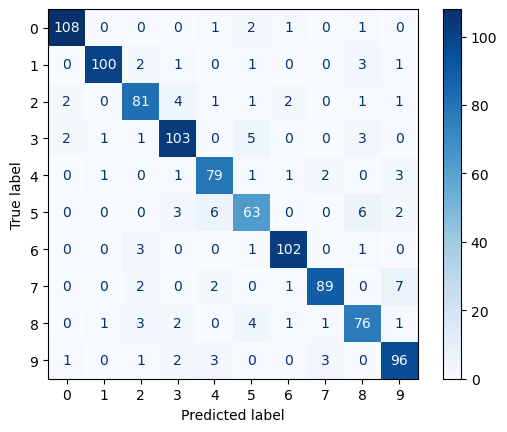

In [126]:
# Visa förvirringsmatris
ConfusionMatrixDisplay.from_estimator(best_model_SGD, X_val_scaled, y_val, cmap='Blues')
plt.show()

In [139]:
param_grid_forest = {
    'n_estimators': [100, 200],   # Antal träd i skogen
    'max_depth': [10, 30],  # Maximalt djup på träden
    'min_samples_split': [2, 5],  # Minsta antal prov för att dela en nod
    'max_features': ['sqrt', 'log2'] #Antalet funktioner vid varje delning
}

grid_search_forest = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_forest,
    scoring='accuracy',
    cv=3,  
    verbose=2,
    n_jobs=1)

try:
    grid_search_forest.fit(X_train_scaled, y_train)
except ValueError as e:
    print("Ett värdefel uppstod:", e)
except NotFittedError as e:
    print("Modellen kunde inte tränas:", e)
except Exception as e:
    print("Ett annat fel uppstod:", e)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  13.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  13.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  13.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   6.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   6.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END max_depth=10, max_features=sqr

In [141]:
best_model_forest = grid_search_forest.best_estimator_
print(f"Bästa parametrar: {grid_search_forest.best_params_}")

Bästa parametrar: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


Accuracy bästa modellen för RandomForestClassifier: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       113
           1       0.95      0.97      0.96       108
           2       0.94      0.89      0.92        93
           3       0.93      0.91      0.92       115
           4       0.93      0.95      0.94        88
           5       0.92      0.91      0.92        80
           6       0.96      0.97      0.97       107
           7       0.93      0.92      0.93       101
           8       0.92      0.92      0.92        89
           9       0.89      0.92      0.91       106

    accuracy                           0.94      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000



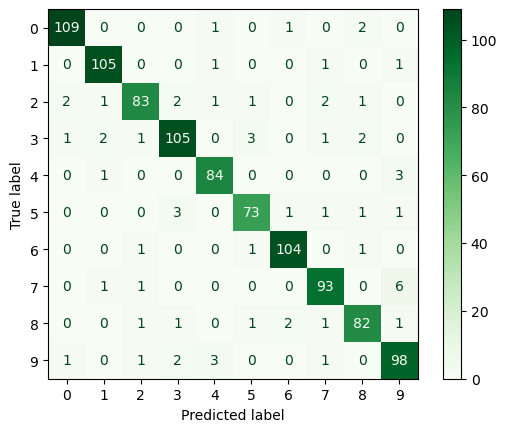

In [143]:
y_pred_val_forest = best_model_forest.predict(X_val_scaled)

accuracy_forest = accuracy_score(y_val, y_pred_val_forest)
print(f"Accuracy bästa modellen för RandomForestClassifier: {accuracy_forest:.2f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val_forest))

ConfusionMatrixDisplay.from_estimator(best_model_forest, X_val_scaled, y_val, cmap='Greens')
plt.show()

## Utvärdering
##### Jag bedömer att Random Forest Classifier ger bättre resultat än SDGClassifier med de parametrar jag har testat.
##### Prediktering av y-värden på testdata och utskrift av accuracy_score, classification_report och ConfusionMatrix visar något sämre resultat än valideringen men accuracy är samma.

Accuracy bästa modellen för RandomForestClassifier: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        99
           1       0.97      0.98      0.98       113
           2       0.96      0.96      0.96        94
           3       0.97      0.90      0.93       108
           4       0.95      0.96      0.95        93
           5       0.94      0.96      0.95        96
           6       0.97      0.97      0.97       101
           7       0.98      0.86      0.92       103
           8       0.91      0.90      0.90        99
           9       0.83      0.96      0.89        94

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.95      0.94      0.94      1000



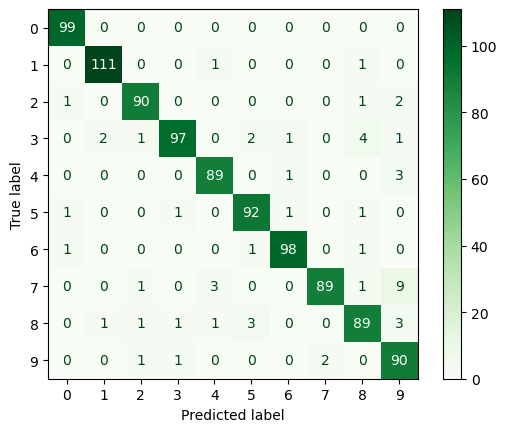

In [147]:
y_pred_test_forest = best_model_forest.predict(X_test_scaled)

accuracy_forest = accuracy_score(y_test, y_pred_test_forest)
print(f"Accuracy bästa modellen för RandomForestClassifier: {accuracy_forest:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_forest))

ConfusionMatrixDisplay.from_estimator(best_model_forest, X_test_scaled, y_test, cmap='Greens')
plt.show()

In [152]:
from joblib import dump

# Spara modellen
dump(best_model_forest, 'best_model_RandomForestClassifier.joblib')

['best_model_RandomForestClassifier.joblib']